# **Clasificador de sonidos de vocales con redes neuronales**
<dl>
    <dt>Machine learning I, </dt>
    <dt>Maestría MACC, </dt>
    <dt>Universidad del Rosario.</dt>
</dl>

**Integrantes**
<dl>
    <dd>Juan Sebastían Cortés, </dd>
    <dd>Juan Sebastían Barrera, </dd>
    <dd>Carlos Garavito.</dd>
</dl>





## Caracterización de las muestras de audio
***

In [1]:
# rutas de trabajo
import os

CURRENT_PATH = os.getcwd()
SAMPLES_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'database')
CSV_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'csv')
MODELS_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'models')
NEWSAMPLES_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'new_samples')
PYTHON_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'python')

In [2]:
# librerias de trabajo
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import h5py
from keras.models import model_from_json
import os 
import glob
import librosa
import soundfile 
import csv
import librosa.display
import sklearn

import sys
sys.path.insert(1, PYTHON_PATH)

# modulos propios
import transform2wav as t2wav
import vowel_classifier as vc

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cgaravitoc/miniconda3/envs/py47/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cgara

Sound is represented in the form of an audio signal having parameters such as frequency, bandwidth, decibel, etc. A typical audio signal can be expressed as a function of Amplitude and Time. A typical audio processing process involves the extraction of acoustics features relevant to the task at hand, followed by decision-making schemes that involve detection, classification, and knowledge fusion. Thankfully we have some useful python libraries which make this task easier.

![alt text](https://miro.medium.com/max/540/0*slh208x5lzN0NloD.png)

Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. The process of extracting features to use them for analysis is called feature extraction. Let us study a few of the features in detail.

The spectral features (frequency-based features), which are obtained by converting the time-based signal into the frequency domain using the Fourier Transform, like fundamental frequency, frequency components, spectral centroid, spectral flux, spectral density, spectral roll-off, etc.

Si apreciamos los dos formantes al unísono, tenemos entonces la caracterización acústica de las 5 vocales fonológicas del español, tal como se muestra en la imagen siguiente (esquema de F1 y F2). [[1](#referencias)]


![alt text](http://domingo-roman.net/imagenes/vocales/castellano/f1-f2-esquema-soto-ruiz.gif)

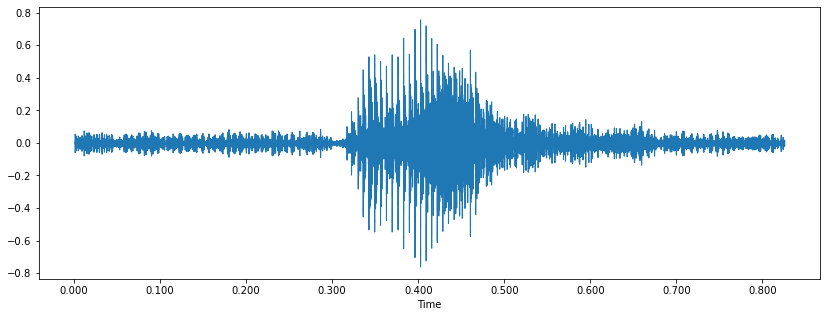

In [3]:
# Cargando una muestra de audio

audio_path = os.path.join(SAMPLES_PATH, 'a', 'a_(56).wav')
audio, sr = librosa.load(audio_path, sr = 16000)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr) # cambiar waveplot por waveshow, para librosa>=0.9

### Espectrograma

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

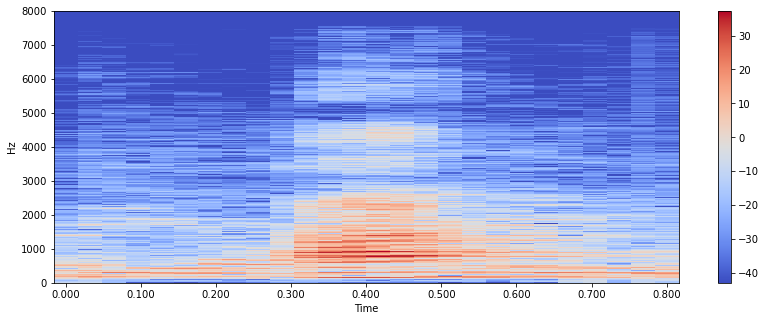

In [4]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### RMS

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut et leo vel lacus vestibulum tristique. Fusce nec nisl justo. Donec tellus leo, rutrum a dui id, sodales tempus risus. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Pellentesque faucibus enim tortor, egestas congue sem consequat quis. Sed in rutrum massa. Nulla vel fringilla eros. Proin mollis ac erat vel egestas. Aliquam pulvinar justo id dui lobortis, quis lobortis purus tempus. 

### Spectral centroid

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. This is like a weighted mean:

![alt text](https://miro.medium.com/max/355/1*DkT47WzLrjigT_KVhDoMuQ.png)

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at bin k.

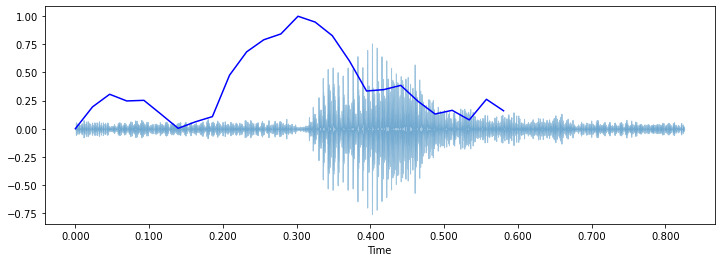

In [5]:
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]
spectral_centroids.shape
#(775,)

# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(audio, axis=0):
    return sklearn.preprocessing.minmax_scale(audio, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(audio, sr=sr, alpha=0.4) # cambiar waveplot por waveshow
plt.plot(t, normalize(spectral_centroids), color='b')

### Spectral bandwith

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

![alt text](https://miro.medium.com/max/515/1*oUtYY0-j6iEc78Dew3d0uA.png)


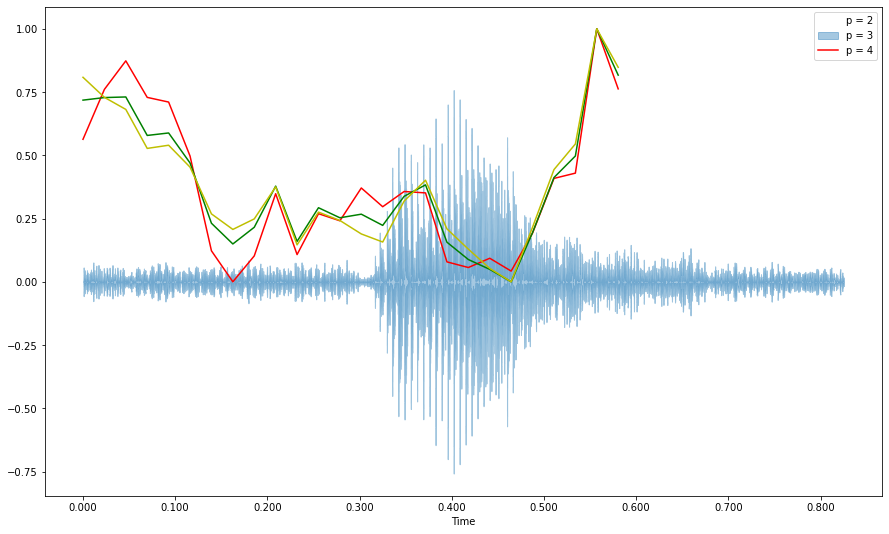

In [6]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))

librosa.display.waveshow(audio, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### Rolloff

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

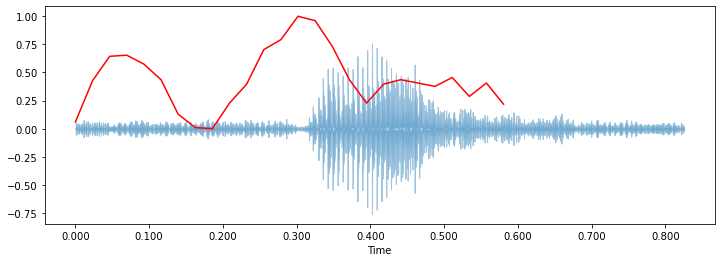

In [7]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))

librosa.display.waveshow(audio, sr=sr, alpha=0.4) # waveshow
plt.plot(t, normalize(spectral_rolloff), color='r')

### Zero cross rate

A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

![alt text](https://miro.medium.com/max/887/1*E_XSqizmLNksjknrD8oV2w.png)

It usually has higher values for highly percussive sounds like those in metal and rock. Now let us visualize it and see how we calculate zero crossing rate.

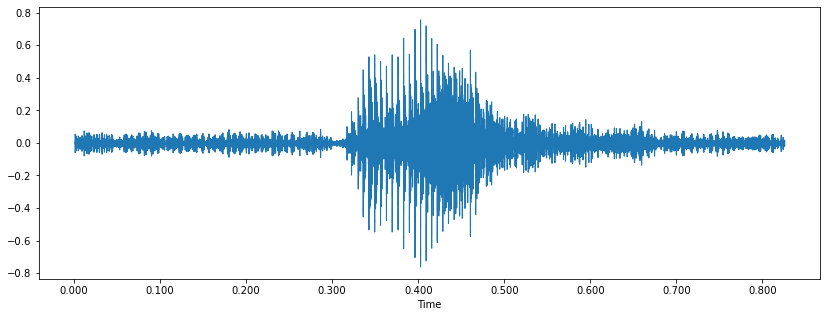

In [8]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)


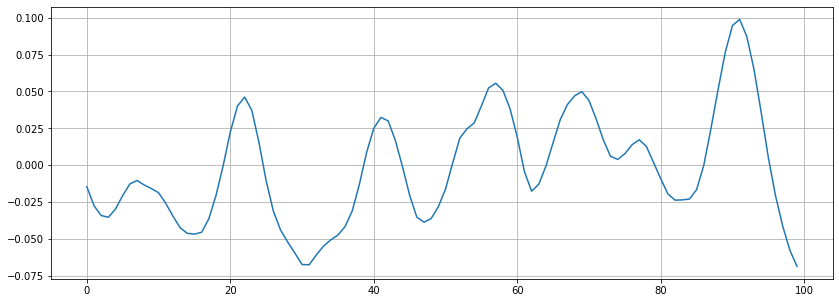

In [9]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(audio[n0:n1])
plt.grid()

In [10]:
zero_crossings = librosa.zero_crossings(audio[n0:n1], pad=False)
print(sum(zero_crossings))

10


### Mel frequencies

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

(20, 26)


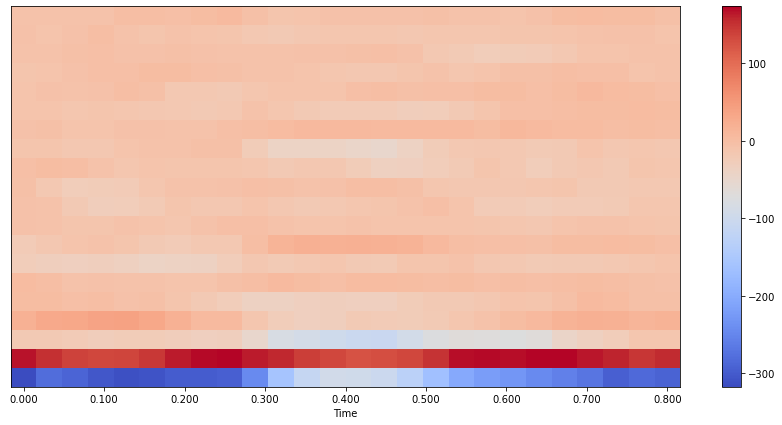

In [11]:
mfccs = librosa.feature.mfcc(audio, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()

## Entrenamiento de la red
***

### Obteniendo caracteristicas de las muestras de audio

Se capturan las caracteristicas de las muestras y se guardan un documento `.csv`:

In [3]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 20): # origianlly is (1,21)
    header += f' mfcc{i}'

header += ' label'
header = header.split()

file = open(os.path.join(CSV_PATH, 'dataset.csv'), 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

vowels = 'a e i o u'.split()

for vowel in vowels:
    for filename in os.listdir(os.path.join(SAMPLES_PATH, f'{vowel}'))[1:]:
        vowel_sample = os.path.join(SAMPLES_PATH, f'{vowel}', filename) 
        if filename == 'desktop.ini': # omite desktop.ini
            break
        y, sr = librosa.load(vowel_sample, mono=True, duration=30)

        rms = librosa.feature.rms(y=y) # The latest librosa replaced rmse with rms, 
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        to_append += f' {vowel}'
        file = open(os.path.join(CSV_PATH, 'dataset.csv'), 'a', newline='')
        
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

### Dividiendo el conjunto de datos en `train`, `test` y `validation`

In [6]:
data = pd.read_csv(os.path.join(CSV_PATH, 'dataset.csv'))
data = data.drop(['filename'],axis=1)

encoder = LabelEncoder()
vowel = data.iloc[:, -1]
y = encoder.fit_transform(vowel)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# partición train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# partición test y validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

data.head()



,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,label
0,0.078352,1349.064787,1579.104290,2411.718750,0.061951,-196.142258,155.342072,-32.792675,9.183998,-6.563315,...,-0.049949,-13.237475,-4.148360,-5.552077,-2.548403,-6.649182,-3.227248,-6.036036,-0.574568,a
1,0.069475,1335.681013,1605.150355,2349.729226,0.058579,-226.859665,156.504669,-21.692404,4.813828,-20.601521,...,3.229920,-8.176623,-6.780771,-7.901219,-3.167109,-8.719459,-2.223617,-6.005474,-1.976870,a
2,0.180722,1230.516329,1298.630581,2052.114258,0.065283,-175.464615,165.534500,-52.409454,-10.623739,-7.834209,...,15.754293,-3.265908,-29.651281,-6.224324,0.542435,-4.551761,0.672431,0.564469,4.498198,a
3,0.164562,1119.214923,1177.865307,1484.607873,0.060955,-187.022491,182.391541,-34.986664,-21.803410,-33.389511,...,-1.105423,1.977387,-26.593988,-14.305027,-2.595483,-30.414909,3.246894,0.130621,-8.242084,a
4,0.127101,1354.373164,1533.664553,2565.692729,0.064758,-186.175797,162.802048,-37.374710,11.754867,-20.215420,...,-0.065242,-5.120680,-18.042542,-8.207775,4.094570,-9.554463,-1.939124,-1.285419,-3.731362,a


### Construyendo la red neuronal

In [7]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',   
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

predict_x = classifier.model.predict(X_test) 
classes_x = np.argmax(predict_x,axis=1)

np.save(os.path.join(MODELS_PATH, 'classes.npy'), classes_x)

Epoch 1/100
8/8 [==============================] - 1s 5ms/step - loss: 1.9299 - accuracy: 0.4197
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 1.1471 - accuracy: 0.7199
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.8161
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4372 - accuracy: 0.8584
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3442 - accuracy: 0.8922
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2874 - accuracy: 0.9112
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2588 - accuracy: 0.9207
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2328 - accuracy: 0.9175
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2109 - accuracy: 0.9334
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1886 - accuracy: 0.9461
Epoch 11/100
8/8 [===========

#### Evaluando la red con los datos de prueba

In [7]:
pred_str = encoder.inverse_transform(classes_x)
test_str = encoder.inverse_transform(y_test)

score = classifier.model.evaluate(X_test, y_test, verbose=0)

print("%s: %.2f%%" % (classifier.model.metrics_names[1], score[1]*100))

accuracy: 88.18%


#### Evaluando la red con los datos de validación

In [ ]:
predict_x=classifier.model.predict(X_val) 
classes_x=np.argmax(predict_x,axis=1)
pred_str = str(encoder.inverse_transform(classes_x))
test_str = encoder.inverse_transform(y_val)
score = classifier.model.evaluate(X_val, y_val, verbose=0)

print("%s: %.2f%%" % (classifier.model.metrics_names[1], score[1]*100))

### Guardando el modelo generado

In [ ]:
# serialize model to JSON
model_json = classifier.model.to_json()

with open(os.path.join(MODELS_PATH, 'model.json'), "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(os.path.join(MODELS_PATH, "model.h5"))
print("Saved model to disk")

## Evaluando nuevas muestras de audio con el modelo generado

Para realizar la clasificación de nuevos audios, el modelo generado en los pasos anteriores es posible ser guardado. En este sentido, es posible correr el modelo obtenido sobre un nuevo conjunto de datos sin la necesidad de entrenar nuevamente la red. Así, para correr nuestro clasificador de audios de vocales, se debe hacer uso del módulo `vowel_classifier`. 

Para ello, se recomienda guardar las nuevas muestras en la carpeta `new_samples`. Los formatos de audio pueden ser `.ogg` (whatsapp), `.m4a` (grabador de audio de win10) o `.wav`. A pesar que la red solamente trabaja con archivos de audio `.wav`, en caso que los audios tengan un formato distinto, se ha implementado el módulo `transform2wav.py` que permite la transformación al formato de trabajo. 

In [1]:
import sys
sys.path.insert(1, PYTHON_PATH)

import transform2wav as t2wav
import vowel_classifier as vc

Para transformar el formato de las muestras de audio a `.wav`, se debe correr la siguiente celda: 

In [2]:
# transforma todas las muestras de audio en formato .wav
t2wav.transform2wav()

[]
[]


Para clasificar las muestas de audio con el modelo obtenido y previamente guardado, se debe correr la siguiente celda: 

In [3]:
my_classifier = vc.my_vowelClassifier(CSV_PATH, NEWSAMPLES_PATH, MODELS_PATH)
my_classifier.csv_creator("dataset_NEW")

X_new, new_data = my_classifier.read_myData()
my_prediction = my_classifier.my_prediction(X_new, new_data)
my_prediction

Loaded model from disk


,new_sample,prediction
0,sample_1.wav,e
1,sample_2.wav,i
2,sample_3.wav,o
3,sample_4.wav,u
4,sample_5.wav,a
5,sample_6.wav,a


## Preguntas

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
> Se oserva que el modelo de redes neuronames encontrado es capaz de clasificar las muestras de audio de las vocales con un $88\%$ de precisión.

2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
> Se elije una red neuronal con cuatro capas ocultas. En todas las capas, excepto la de salida, las neuronas tienen como función de activación a la RELU; mientras que en la capa de salida se tiene SOFTMAX. El criterio para seleccionar esta arquitectura fue el de obtener la máxima precisión posible aprovechando los recursos de hardware disponibles. 

3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
> Si, la red tiene el comportamiento esperado ya que esta en capacidad de clasificar audios de vocales. Esto es, debido a que la red ha sido entrenada con datos etiquetados, con varias iteraciones sobre el conjunto de datos. 

4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?
> La mejora consiste en que la red pueda clasificar correctamente muestras de audio con un nivel de ruido mayor. Para ello, se implementaria un paso adicional que consiste en limpiar las muestas de audio de entrenamiento, para luego volver a generar el modelo. 

# Referencias

[1] [Caracterización acústica de las vocales del español](http://domingo-roman.net/vocales_esp_caract_acustica.html)

[2] [Audio Data Analysis Using Deep Learning with Python (Part 1)](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)